The following kernels influenced my approach:
- [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) by Serigne 
- [Kaggle Competition - House Prices: Advanced Regression Techniques](https://www.kaggle.com/hamzaben/tuned-random-forest-lasso-and-xgboost-regressors) by Hazma B
- [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by Pedro Marcelino


# Importing Libraries and Datasets

In [21]:
# import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

import os


### Set prefs

In [22]:
# Seaborn
color = sns.color_palette()
sns.set_style('darkgrid')

# Data formats
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))



### Import data files

In [23]:
# List files available in the "./input/" directory.

!ls ./data
# Any results written to the current directory are saved as output.

melb_data.csv		    test.csv   train.csv
Melbourne_housing_FULL.csv  test.xlsx  train.xlsx


In [24]:
# Import train and test data sets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# making copies of original datasets for rest of this kernel
df_train = train.copy()
df_test = test.copy()

In [25]:
print(df_train.shape, df_test.shape)

(1460, 81) (1459, 80)


In [6]:
# display the first five rows of the train dataset.
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# display the first five rows of the test dataset.
df_test.head(5)



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
# Specify target variable and remove from training data set
#  target = df_train['SalePrice']  #target variable
# df_train = df_train.drop('SalePrice', axis=1) #drop target variable from training dataset

In [9]:
#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']


In [10]:
# Drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

# Exploratory Data Analysis

In [11]:
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [12]:
df_train.shape

(1460, 80)

In [13]:
# List variable types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [14]:
# group by variable type
df_train.columns.to_series().groupby(df_train.dtypes).groups

{dtype('int64'): Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
        'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtC

### Sale Price exploration

In [15]:
df_train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

In [16]:
median_price = np.median(df_train['SalePrice'])
print(median_price)

163000.0


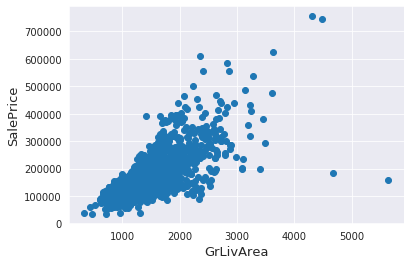

In [17]:
# Look for outliers
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

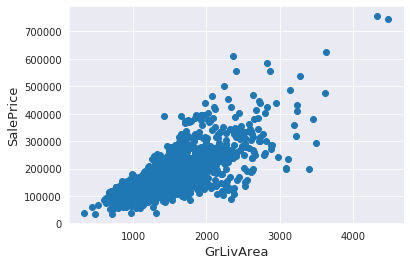

In [18]:
#Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



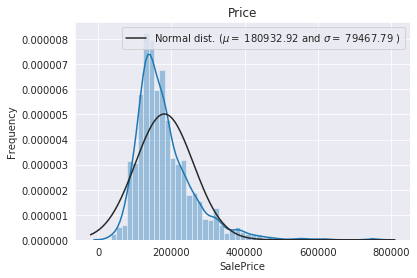

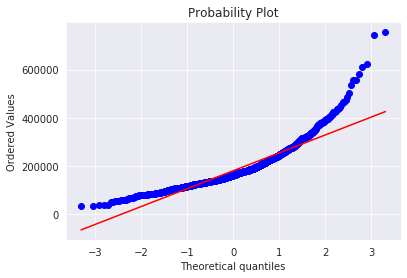

In [20]:
# let's plot a histogram with the fitted parameters used by the function
sns.distplot(df_train['SalePrice'] , fit=norm);

# get mean and standard deviation
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Create the plot
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()


In [22]:
print("Skewness: %f" % train['SalePrice'].skew())

Skewness: 1.882876



 mu = 12.02 and sigma = 0.40



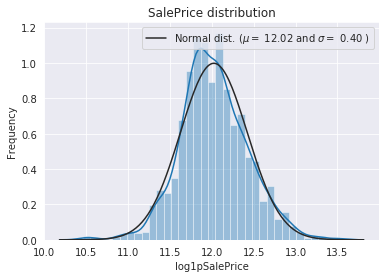

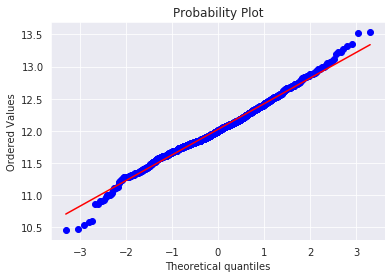

In [23]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_train["log1pSalePrice"] = np.log1p(df_train["SalePrice"])

#Check the new distribution 
sns.distplot(df_train["log1pSalePrice"] , fit=norm);

# get mean and standard deviation
(mu, sigma) = norm.fit(df_train["log1pSalePrice"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train["log1pSalePrice"], plot=plt)
plt.show()

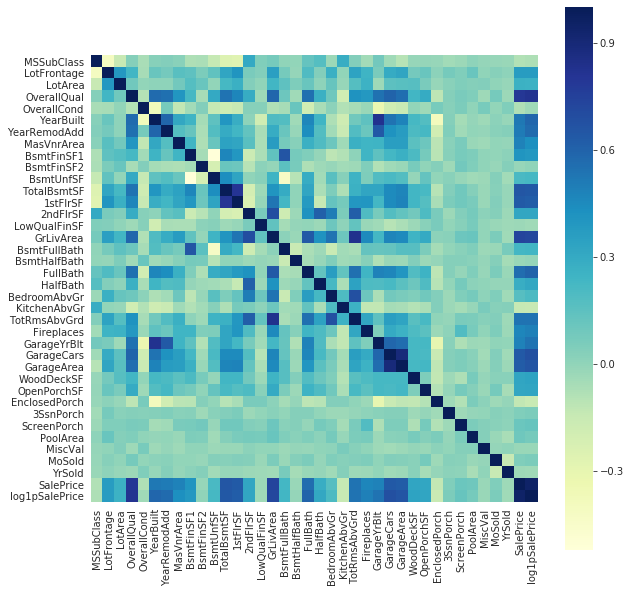

In [24]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df_train.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat,square=True, cmap="YlGnBu");

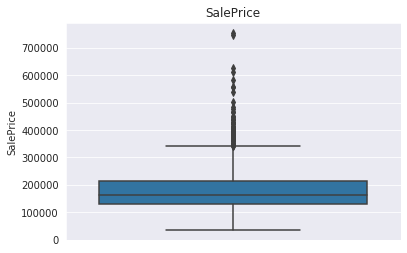

In [25]:
sns.boxplot(y = df_train['SalePrice'])
plt.title('SalePrice');

/home/mike/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/mike/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


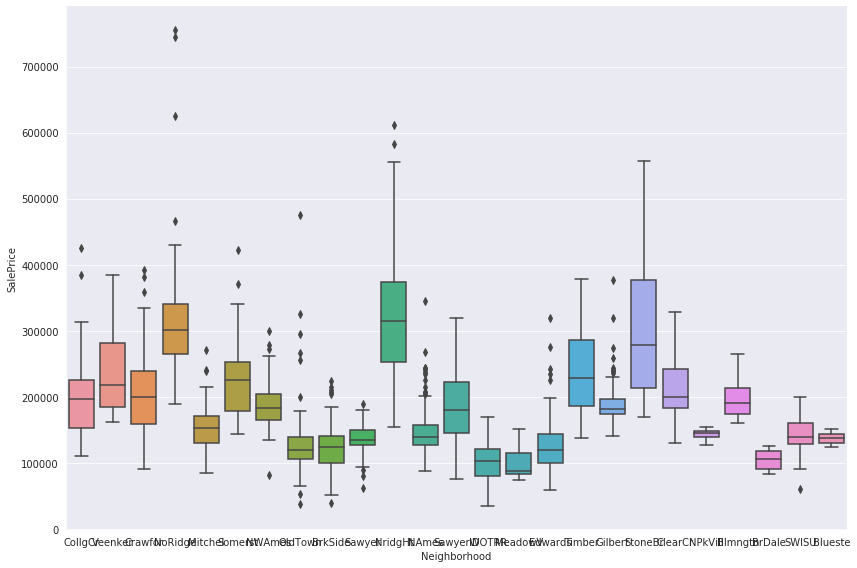

In [26]:
sns.factorplot(kind='box',        # Boxplot
               y='SalePrice',         # Y-axis - values for boxplot
               x='Neighborhood',      # X-axis - first factor
               data=df_train,   # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot
plt.show()

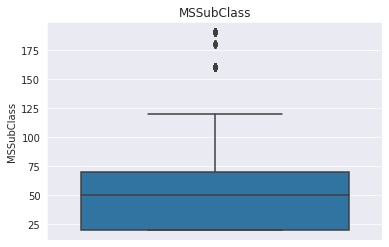

In [27]:
sns.boxplot(y = df_train['MSSubClass'])
plt.title('MSSubClass');

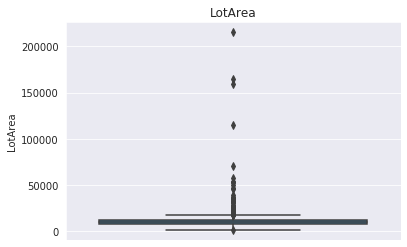

In [28]:
sns.boxplot(y = df_train['LotArea'])
plt.title('LotArea');

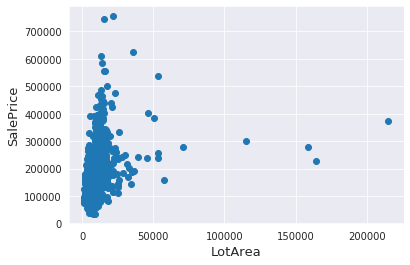

In [29]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['LotArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

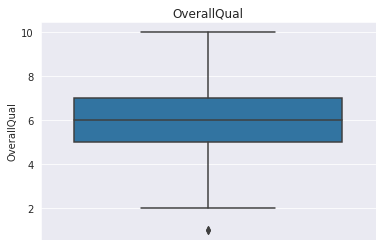

In [30]:
sns.boxplot(y = df_train['OverallQual'])
plt.title('OverallQual');

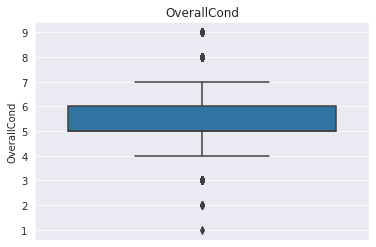

In [31]:
sns.boxplot(y = df_train['OverallCond'])
plt.title('OverallCond');

In [32]:
'YearBuilt',
'YearRemodAdd', 
'BsmtFinSF1', 
'BsmtFinSF2', 
'BsmtUnfSF', 
'TotalBsmtSF',
'1stFlrSF', 
'2ndFlrSF', 
'LowQualFinSF', 
'GrLivArea', 
'BsmtFullBath',
'BsmtHalfBath', 
'FullBath', 
'HalfBath', 
'BedroomAbvGr', 
'KitchenAbvGr',
'TotRmsAbvGrd', 
'Fireplaces', 
'GarageCars', 
'GarageArea', 
'WoodDeckSF',
'OpenPorchSF', 
'EnclosedPorch', 
'3SsnPorch', 
'ScreenPorch', 
'PoolArea',
'MiscVal', 
'MoSold', 
'YrSold', 
'SalePrice'

'SalePrice'

In [33]:
df_train['training_set'] = True #adding an extra variable to training and testing dataset before joining them
df_test['training_set'] = False
df_full = pd.concat([df_train, df_test]) #concatenate both dataframes prior to EDA

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


- Should outliers be removed?
- Type of log transformation; np.log or np.log1p